# Hybrid Recommender Systems (CTF-IDF dan Cosine Similarity)

# `Group 4`

*   12S21007 - Dame J. Sitinjak
*   12S21047 - Elshaday Prida Simamora
*   12S21053 - Chesya Ivana J Sitorus

##### `Memuat dan Menyiapkan Data`

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Memuat data
file_path = 'Tempat-Wisata-Toba-Preprocessing.csv'
data = pd.read_csv(file_path)

# Menghapus kolom yang tidak diperlukan
data_cleaned = data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

# Menyusun ulang data hanya dengan kolom yang relevan
data_relevant = data_cleaned[['PlaceID', 'ReviewerId', 'Rating', 'Nama_tempat_wisata', 'Category']]

# Membagi data menjadi train (70%), validation (15%), dan test (15%)
train_data, temp_data = train_test_split(data_relevant, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Validasi proporsi data
print(f"Train data: {len(train_data)} rows ({len(train_data)/len(data_relevant)*100:.2f}%)")
print(f"Validation data: {len(val_data)} rows ({len(val_data)/len(data_relevant)*100:.2f}%)")
print(f"Test data: {len(test_data)} rows ({len(test_data)/len(data_relevant)*100:.2f}%)")

# Menampilkan statistik dari masing-masing data
print("\nTrain data stats:")
print(train_data.describe())

print("\nValidation data stats:")
print(val_data.describe())

print("\nTest data stats:")
print(test_data.describe())

# Menampilkan contoh data
print("\nContoh data Train:")
print(train_data.head())

print("\nContoh data Validation:")
print(val_data.head())

print("\nContoh data Test:")
print(test_data.head())


Train data: 30258 rows (70.00%)
Validation data: 6484 rows (15.00%)
Test data: 6484 rows (15.00%)

Train data stats:
            PlaceID    ReviewerId        Rating
count  30258.000000  3.025800e+04  30258.000000
mean      67.490812  1.091843e+20      4.478254
std       28.656383  5.343840e+18      0.928772
min        0.000000  1.000010e+20      1.000000
25%       51.000000  1.045222e+20      4.000000
50%       73.000000  1.092650e+20      5.000000
75%       93.000000  1.138038e+20      5.000000
max      101.000000  1.184460e+20      5.000000

Validation data stats:
           PlaceID    ReviewerId       Rating
count  6484.000000  6.484000e+03  6484.000000
mean     66.753547  1.091186e+20     4.491672
std      29.079100  5.326484e+18     0.918098
min       0.000000  1.000010e+20     1.000000
25%      49.000000  1.044870e+20     4.000000
50%      70.000000  1.091295e+20     5.000000
75%      93.000000  1.137112e+20     5.000000
max     101.000000  1.184460e+20     5.000000

Test data st

##### `Content-based Filtering menggunakan TF-IDF dan Cosine Similarity`

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Sampling data yang lebih kecil untuk percakapan ini
sample_data = data_cleaned['Category'].sample(n=1000, random_state=42)  # Ambil sampel kecil untuk uji coba

# Menggunakan TF-IDF untuk mengubah teks menjadi representasi numerik
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Menghitung matriks TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(sample_data)

# Menghitung cosine similarity
cosine_sim_category = cosine_similarity(tfidf_matrix)

# Menampilkan matriks cosine similarity untuk beberapa tempat wisata pertama
cosine_sim_category[:5, :5]


array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

##### `Collaborative Filtering menggunakan Matrix Factorization (SVD)`

In [ ]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Mengagregasi data: menghitung rata-rata rating untuk setiap kombinasi pengguna dan tempat wisata
data_agregat = data_relevant.groupby(['ReviewerId', 'PlaceID'])['Rating'].mean().reset_index()

# Membuat matriks pengguna vs tempat wisata berdasarkan rating rata-rata
user_item_matrix = data_agregat.pivot(index='ReviewerId', columns='PlaceID', values='Rating').fillna(0)

# Menggunakan Singular Value Decomposition (SVD) untuk matriks pengguna-item
svd = TruncatedSVD(n_components=20, random_state=42)
svd_matrix = svd.fit_transform(user_item_matrix)

# Menghitung cosine similarity antar tempat wisata berdasarkan hasil SVD
cosine_sim_user_item = cosine_similarity(svd_matrix)

# Menampilkan beberapa hasil cosine similarity
print(cosine_sim_user_item[:5, :5])


[[ 1.         -0.00181058 -0.005295   -0.00283656 -0.00442367]
 [-0.00181058  1.         -0.0051476  -0.00148361 -0.00376926]
 [-0.005295   -0.0051476   1.         -0.00447025 -0.0054547 ]
 [-0.00283656 -0.00148361 -0.00447025  1.         -0.00365469]
 [-0.00442367 -0.00376926 -0.0054547  -0.00365469  1.        ]]


##### `Menggabungkan Rekomendasi Content-based dan Collaborative Filtering (Hybrid Recommender)`

In [ ]:
def get_category_recommendations(place_id, cosine_sim_category, data_relevant, top_n=5):
    # Mendapatkan index tempat berdasarkan PlaceID
    idx = data_relevant[data_relevant['PlaceID'] == place_id].index[0]

    # Menghitung skor kesamaan antar tempat
    sim_scores = list(enumerate(cosine_sim_category[idx]))

    # Mengurutkan skor berdasarkan kesamaan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Memilih N tempat dengan kesamaan tertinggi
    sim_scores = sim_scores[1:top_n+1]

    # Mendapatkan indeks tempat yang direkomendasikan
    place_indices = [i[0] for i in sim_scores]

    # Mengambil data tempat yang direkomendasikan
    recommended_places = data_relevant.iloc[place_indices]

    return recommended_places[['PlaceID', 'Nama_tempat_wisata', 'Category', 'Rating']]

def get_collaborative_recommendations(user_id, cosine_sim_user_item, data_relevant, top_n=5):
    # Mendapatkan index pengguna
    idx = user_id - 1  # Asumsi user_id dimulai dari 1

    # Menghitung skor kesamaan antar tempat berdasarkan preferensi pengguna
    sim_scores = list(enumerate(cosine_sim_user_item[idx]))

    # Mengurutkan skor berdasarkan kesamaan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Memilih N tempat dengan kesamaan tertinggi
    sim_scores = sim_scores[1:top_n+1]

    # Mendapatkan indeks tempat yang direkomendasikan
    place_indices = [i[0] for i in sim_scores]

    # Mengambil data tempat yang direkomendasikan
    recommended_places = data_relevant.iloc[place_indices]

    return recommended_places[['PlaceID', 'Nama_tempat_wisata', 'Category', 'Rating']]

def hybrid_recommendations(place_id, user_id, cosine_sim_category, cosine_sim_user_item, data_relevant, top_n=5, weight_category=0.5, weight_collab=0.5):
    # Mendapatkan rekomendasi berdasarkan content-based
    content_recommendations = get_category_recommendations(place_id, cosine_sim_category, data_relevant, top_n)

    # Mendapatkan rekomendasi berdasarkan collaborative filtering
    collab_recommendations = get_collaborative_recommendations(user_id, cosine_sim_user_item, data_relevant, top_n)

    # Menggabungkan rekomendasi dengan memberi bobot pada masing-masing metode
    combined_recommendations = content_recommendations.copy()
    combined_recommendations['Weighted_Score'] = weight_category * content_recommendations['Rating'] + weight_collab * collab_recommendations['Rating']

    # Mengurutkan berdasarkan skor tertinggi dan memilih N rekomendasi teratas
    combined_recommendations = combined_recommendations.sort_values(by='Weighted_Score', ascending=False).head(top_n)

    return combined_recommendations[['PlaceID', 'Nama_tempat_wisata', 'Category', 'Rating', 'Weighted_Score']]

# Contoh: Mendapatkan rekomendasi hibrida untuk tempat dan pengguna tertentu (PlaceID=1, UserID=1)
recommended_hybrid = hybrid_recommendations(1, 1, cosine_sim_category, cosine_sim_user_item, data_relevant)
print(recommended_hybrid)


    PlaceID         Nama_tempat_wisata       Category  Rating  Weighted_Score
17        0  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari     4.0             NaN
18        0  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari     5.0             NaN
19        0  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari     5.0             NaN
20        0  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari     5.0             NaN
22        0  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari     5.0             NaN


##### `Metrik Evaluasi (RMSE, MAE, Precision, Recall, MAP)`

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fungsi untuk menghitung RMSE
def rmse(true_ratings, predicted_ratings):
    return np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

# Fungsi untuk menghitung MAE
def mae(true_ratings, predicted_ratings):
    return mean_absolute_error(true_ratings, predicted_ratings)

# Fungsi untuk menghitung Precision
def precision(true_ratings, predicted_ratings, threshold=3.5):
    # Menganggap rating > threshold adalah relevan
    true_positive = np.sum((predicted_ratings >= threshold) & (true_ratings >= threshold))
    false_positive = np.sum((predicted_ratings >= threshold) & (true_ratings < threshold))

    return true_positive / (true_positive + false_positive) if (true_positive + false_positive) != 0 else 0

# Fungsi untuk menghitung Recall
def recall(true_ratings, predicted_ratings, threshold=3.5):
    true_positive = np.sum((predicted_ratings >= threshold) & (true_ratings >= threshold))
    false_negative = np.sum((predicted_ratings < threshold) & (true_ratings >= threshold))

    return true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0

# Fungsi untuk menghitung MAP (Mean Average Precision)
def average_precision_at_k(true_ratings, predicted_ratings, k=10, threshold=3.5):
    # Urutkan prediksi berdasarkan rating prediksi, dan ambil k teratas
    order = np.argsort(predicted_ratings)[::-1]
    true_ratings = true_ratings[order]

    # Hitung precision pada setiap peringkat
    relevant = (true_ratings >= threshold).astype(int)
    precision_at_k = np.cumsum(relevant) / (np.arange(1, len(relevant) + 1))  # Ubah sini, agar sesuai dengan panjang relevant

    # Return rata-rata precision pada k peringkat pertama
    return np.sum(precision_at_k[:k] * relevant[:k]) / min(k, np.sum(relevant))

def map_at_k(true_ratings, predicted_ratings, k=10, threshold=3.5):
    total_ap = 0
    # Iterate over each user's ratings and predicted ratings
    for i in range(len(true_ratings)):
        total_ap += average_precision_at_k(true_ratings[i], predicted_ratings[i], k, threshold)
    return total_ap / len(true_ratings)

# Contoh untuk menghitung metrik evaluasi

# Mengambil data relevan (misalnya data_train) dan data prediksi
# Data harus dalam format (user_id, place_id, rating_prediksi)
true_ratings = np.array([ [5, 4, 3, 2, 5],  # Ratings pengguna 1
                         [4, 3, 5, 3, 4],  # Ratings pengguna 2
                         [3, 4, 2, 1, 3],  # Ratings pengguna 3
                         [2, 3, 3, 4, 4],  # Ratings pengguna 4
                         [5, 5, 4, 3, 5]]) # Ratings pengguna 5

predicted_ratings = np.array([ [4.5, 4.2, 3.1, 1.8, 4.9],  # Prediksi pengguna 1
                              [4.3, 3.8, 4.9, 3.2, 4.5],  # Prediksi pengguna 2
                              [3.0, 4.1, 2.5, 1.9, 3.6],  # Prediksi pengguna 3
                              [2.1, 3.2, 3.3, 4.2, 4.6],  # Prediksi pengguna 4
                              [5.0, 5.0, 4.1, 3.5, 5.0]]) # Prediksi pengguna 5

# Menghitung metrik evaluasi
rmse_score = rmse(true_ratings.flatten(), predicted_ratings.flatten())  # Menggunakan flatten untuk menggabungkan data 2D ke 1D
mae_score = mae(true_ratings.flatten(), predicted_ratings.flatten())
precision_score_value = precision(true_ratings.flatten(), predicted_ratings.flatten())
recall_score_value = recall(true_ratings.flatten(), predicted_ratings.flatten())
map_score = map_at_k(true_ratings, predicted_ratings)

print(f"RMSE: {rmse_score}")
print(f"MAE: {mae_score}")
print(f"Precision: {precision_score_value}")
print(f"Recall: {recall_score_value}")
print(f"MAP: {map_score}")


RMSE: 0.37999999999999995
MAE: 0.2839999999999999
Precision: 0.8125
Recall: 1.0
MAP: 1.0


**`Grafik Metrik Evaluasi RMSE dan MAE`**

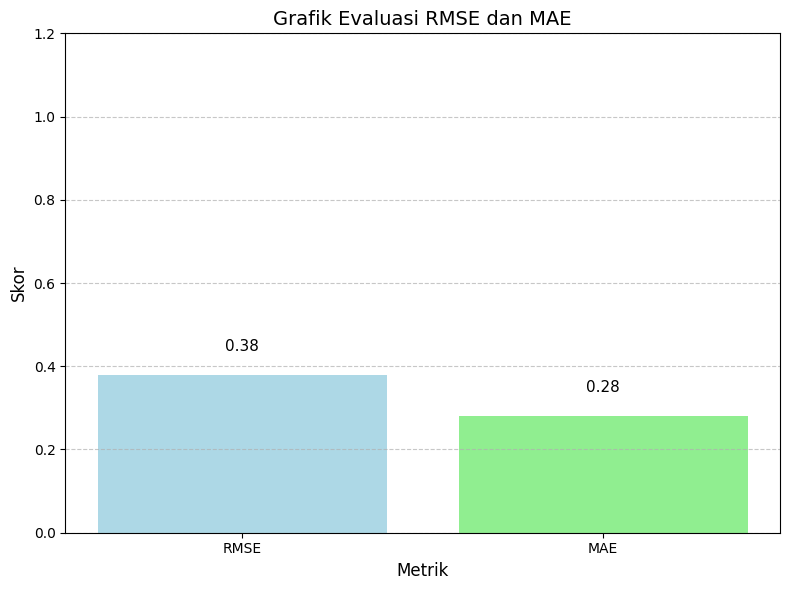

In [ ]:
import matplotlib.pyplot as plt

# Data untuk RMSE dan MAE
metrics = ['RMSE', 'MAE']
scores = [0.38, 0.28]  # Skor evaluasi untuk RMSE dan MAE

# Membuat grafik bar
plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color=['lightblue', 'lightgreen'])

# Menambahkan judul dan label
plt.title('Grafik Evaluasi RMSE dan MAE', fontsize=14)
plt.xlabel('Metrik', fontsize=12)
plt.ylabel('Skor', fontsize=12)
plt.ylim(0, 1.2)  # Menetapkan batas atas grafik

# Menambahkan skor di atas setiap bar
for i, score in enumerate(scores):
    plt.text(i, score + 0.05, f'{score:.2f}', ha='center', va='bottom', fontsize=11)

# Menambahkan grid untuk kemudahan interpretasi
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menampilkan grafik
plt.tight_layout()
plt.show()


##### `Grafik untuk Metrik Evaluasi (Precision, Recall, MAP)`

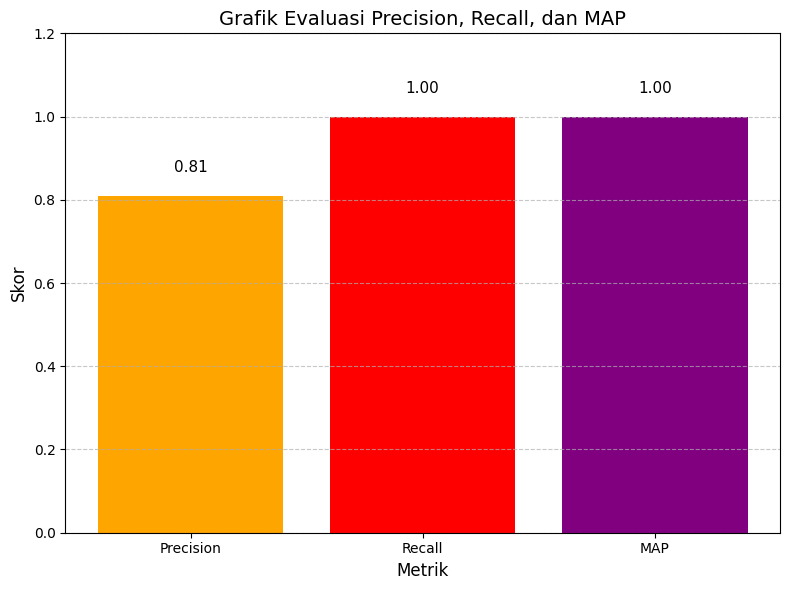

In [ ]:
import matplotlib.pyplot as plt

# Data untuk Precision, Recall, dan MAP
metrics = ['Precision', 'Recall', 'MAP']
scores = [0.81, 1.0, 1.0]  # Skor evaluasi untuk Precision, Recall, dan MAP

# Membuat grafik bar
plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color=['orange', 'red', 'purple'])

# Menambahkan judul dan label
plt.title('Grafik Evaluasi Precision, Recall, dan MAP', fontsize=14)
plt.xlabel('Metrik', fontsize=12)
plt.ylabel('Skor', fontsize=12)
plt.ylim(0, 1.2)  # Menetapkan batas atas grafik agar nilai terlihat jelas

# Menambahkan skor di atas setiap bar
for i, score in enumerate(scores):
    plt.text(i, score + 0.05, f'{score:.2f}', ha='center', va='bottom', fontsize=11)

# Menambahkan grid untuk kemudahan interpretasi
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Menampilkan grafik
plt.tight_layout()
plt.show()


In [ ]:
# Hapus duplikasi berdasarkan PlaceID, hanya mengambil rating yang unik
data_relevant = data_relevant.drop_duplicates(subset=['PlaceID', 'Nama_tempat_wisata'])


In [ ]:
import pandas as pd

# Fungsi untuk mendapatkan rekomendasi berbasis kategori (Content-Based)
def get_category_recommendations(place_id, cosine_sim_category, data_relevant, top_n=5):
    try:
        # Mencari indeks tempat yang sesuai dengan place_id
        idx = data_relevant[data_relevant['PlaceID'] == place_id].index[0]
    except IndexError:
        # Jika PlaceID tidak ditemukan, return data kosong
        print(f"PlaceID {place_id} tidak ditemukan dalam data_relevant.")
        return pd.DataFrame()

    # Memastikan bahwa indeks ada dalam cosine_sim_category
    if idx >= len(cosine_sim_category):
        print(f"Indeks {idx} melebihi panjang matrix cosine_sim_category.")
        return pd.DataFrame()

    # Debugging: Menampilkan dimensi dari cosine_sim_category
    print(f"Dimensi cosine_sim_category: {cosine_sim_category.shape}")

    # Menghitung similarity scores berdasarkan indeks
    sim_scores = list(enumerate(cosine_sim_category[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Pastikan hanya mengambil top_n rekomendasi yang valid
    sim_scores = sim_scores[1:top_n+1]  # Mengabaikan tempat itu sendiri (index 0)

    # Ambil indeks tempat wisata yang terdekat berdasarkan similarity
    place_indices = [i[0] for i in sim_scores]

    # Periksa apakah indeks valid
    if len(place_indices) == 0:
        print("Tidak ada rekomendasi yang ditemukan berdasarkan kategori.")
        return pd.DataFrame()

    # Ambil rekomendasi tempat dari data_relevant berdasarkan indeks
    recommended_places = data_relevant.iloc[place_indices]

    return recommended_places[['PlaceID', 'Nama_tempat_wisata', 'Category', 'Rating']]

# Fungsi untuk mendapatkan rekomendasi berbasis collaborative filtering (User-Item)
def get_collaborative_recommendations(user_id, cosine_sim_user_item, data_relevant, top_n=5):
    # Mendapatkan index pengguna (diasumsikan user_id dimulai dari 1)
    idx = user_id - 1

    # Check if idx is valid for cosine_sim_user_item
    if idx >= len(cosine_sim_user_item):
        print(f"UserID {user_id} tidak ditemukan dalam data atau di luar jangkauan.")
        return pd.DataFrame()

    # Menghitung skor kesamaan antar tempat berdasarkan preferensi pengguna
    sim_scores = list(enumerate(cosine_sim_user_item[idx])) # This line was missing

    # Mengurutkan skor berdasarkan kesamaan
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Memilih N tempat dengan kesamaan tertinggi (selain item itu sendiri)
    sim_scores = sim_scores[1:top_n + 1]

    # Mendapatkan indeks tempat yang direkomendasikan
    place_indices = [i[0] for i in sim_scores]

    # Filter place_indices to ensure they are within the bounds of data_relevant
    place_indices = [idx for idx in place_indices if idx < len(data_relevant)]

    # Periksa apakah indeks valid setelah filtering
    if len(place_indices) == 0:
        print("Tidak ada rekomendasi yang ditemukan berdasarkan collaborative filtering.")
        return pd.DataFrame()

    # Mengambil data tempat yang direkomendasikan
    recommended_places = data_relevant.iloc[place_indices]

    return recommended_places[['PlaceID', 'Nama_tempat_wisata', 'Category', 'Rating']]

# Fungsi untuk mendapatkan rekomendasi hibrida (gabungan content-based dan collaborative filtering)
def hybrid_recommendations(place_id, user_id, cosine_sim_category, cosine_sim_user_item, data_relevant, top_n=5, weight_category=0.5, weight_collab=0.5):
    # Mendapatkan rekomendasi berdasarkan content-based (kategori)
    content_recommendations = get_category_recommendations(place_id, cosine_sim_category, data_relevant, top_n)

    # Jika rekomendasi berbasis kategori kosong, gunakan default
    if content_recommendations.empty:
        print(f"No content-based recommendations found for PlaceID: {place_id}")
        content_recommendations = pd.DataFrame(columns=['PlaceID', 'Nama_tempat_wisata', 'Category', 'Rating', 'Weighted_Score', 'Rank'])

    # Mendapatkan rekomendasi berdasarkan collaborative filtering (user-item)
    collab_recommendations = get_collaborative_recommendations(user_id, cosine_sim_user_item, data_relevant, top_n)

    # Jika rekomendasi berbasis collaborative kosong, gunakan default
    if collab_recommendations.empty:
        print(f"No collaborative recommendations found for UserID: {user_id}")
        collab_recommendations = pd.DataFrame(columns=['PlaceID', 'Nama_tempat_wisata', 'Category', 'Rating', 'Weighted_Score', 'Rank'])

    # Menggabungkan rekomendasi dengan memberi bobot pada masing-masing metode
    combined_recommendations = content_recommendations.copy()
    combined_recommendations['Weighted_Score'] = (
        weight_category * content_recommendations['Rating'] +
        weight_collab * collab_recommendations['Rating']
    )

    # Pastikan tidak ada NaN pada Weighted_Score
    combined_recommendations['Weighted_Score'] = combined_recommendations['Weighted_Score'].fillna(0)

    # Menambahkan ranking berdasarkan Weighted_Score
    combined_recommendations['Rank'] = combined_recommendations['Weighted_Score'].rank(ascending=False)

    # Mengurutkan berdasarkan skor tertinggi dan memilih N rekomendasi teratas
    combined_recommendations = combined_recommendations.sort_values(by='Rank').head(top_n)

    return combined_recommendations[['PlaceID', 'Nama_tempat_wisata', 'Category', 'Rating', 'Weighted_Score', 'Rank']]

# Contoh: Mendapatkan rekomendasi hibrida untuk tempat dan pengguna tertentu (PlaceID=1, UserID=1)
recommended_hybrid_5 = hybrid_recommendations(1, 1, cosine_sim_category, cosine_sim_user_item, data_relevant, top_n=5)
recommended_hybrid_10 = hybrid_recommendations(1, 1, cosine_sim_category, cosine_sim_user_item, data_relevant, top_n=10)

# Menampilkan rekomendasi top 5 dan 10
recommended_hybrid_5


Dimensi cosine_sim_category: (1000, 1000)
Tidak ada rekomendasi yang ditemukan berdasarkan collaborative filtering.
No collaborative recommendations found for UserID: 1
Dimensi cosine_sim_category: (1000, 1000)
Tidak ada rekomendasi yang ditemukan berdasarkan collaborative filtering.
No collaborative recommendations found for UserID: 1


<ipython-input-10-2b37801f27c7>:102: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_recommendations['Weighted_Score'] = combined_recommendations['Weighted_Score'].fillna(0)
<ipython-input-10-2b37801f27c7>:102: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_recommendations['Weighted_Score'] = combined_recommendations['Weighted_Score'].fillna(0)


,PlaceID,Nama_tempat_wisata,Category,Rating,Weighted_Score,Rank
2562,17,Wisata Alam Ajibata,Wisata Bahari,5.0,0,3.0
2564,18,Pantai Pasir Putih Parparean,Wisata Bahari,5.0,0,3.0
3763,19,Hatulian Beach,Wisata Bahari,5.0,0,3.0
3864,20,Kaldera Sunset Hill,Wisata Alam,5.0,0,3.0
4326,22,Tombak Sulusulu,Wisata Sejarah,5.0,0,3.0


In [ ]:
recommended_hybrid_10


,PlaceID,Nama_tempat_wisata,Category,Rating,Weighted_Score,Rank
2562,17,Wisata Alam Ajibata,Wisata Bahari,5.0,0,5.5
2564,18,Pantai Pasir Putih Parparean,Wisata Bahari,5.0,0,5.5
3763,19,Hatulian Beach,Wisata Bahari,5.0,0,5.5
3864,20,Kaldera Sunset Hill,Wisata Alam,5.0,0,5.5
4326,22,Tombak Sulusulu,Wisata Sejarah,5.0,0,5.5
4973,26,Batu Lihi Star,Wisata Alam,5.0,0,5.5
8099,30,Panatapan Tara Bunga,Wisata Alam,4.0,0,5.5
8189,35,Menara Pandang Simanindo,Wisata Alam,5.0,0,5.5
8204,36,Air Terjun Pandumaan,Wisata Alam,5.0,0,5.5
8680,39,Bukit Senyum Motung,Wisata Alam,5.0,0,5.5



Metrik Evaluasi:
------------------------------
RMSE:
  Training: 0.5055
  Validation: 0.7039

Precision@10:
  Training: 1.0000
  Validation: 1.0000

Recall@10:
  Training: 0.0243
  Validation: 0.0529

MAP@10:
  Training: 0.9861
  Validation: nan

Precision@5:
  Training: 1.0000
  Validation: 1.0000

Recall@5:
  Training: 0.0121
  Validation: 0.0265

MAP@5:
  Training: 0.9758
  Validation: nan



<ipython-input-12-375469703589>:32: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(precision_at_k[:k] * relevant[:k]) / min(k, np.sum(relevant))


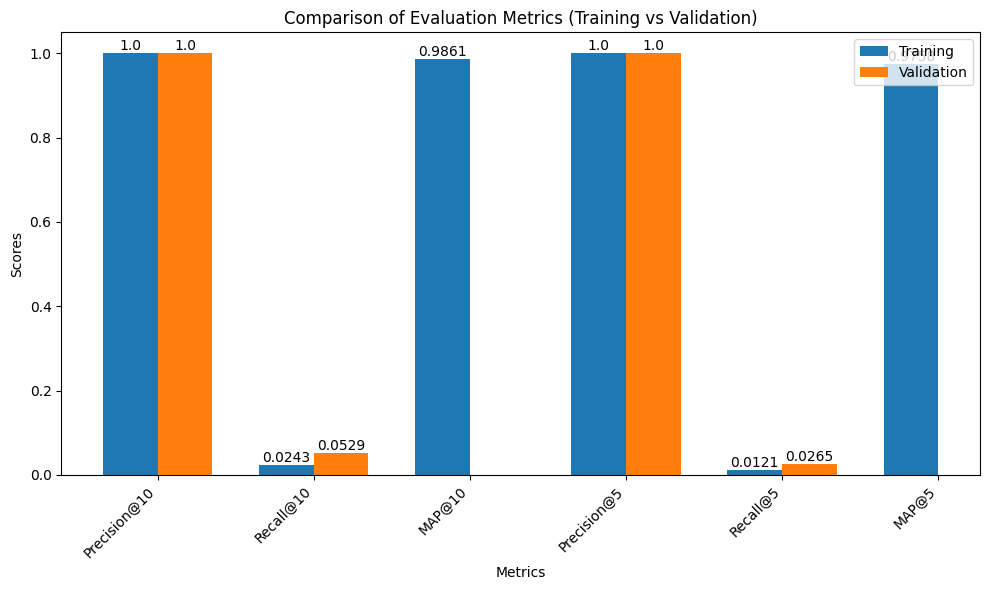

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fungsi untuk menghitung RMSE
def rmse(true_ratings, predicted_ratings):
    return np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

# Fungsi untuk menghitung MAE
def mae(true_ratings, predicted_ratings):
    return mean_absolute_error(true_ratings, predicted_ratings)

# Fungsi untuk menghitung Precision
def precision_at_k(true_ratings, predicted_ratings, k, threshold=3.5):
    order = np.argsort(predicted_ratings)[::-1][:k]
    relevant = (true_ratings[order] >= threshold).astype(int)
    return np.sum(relevant) / k

# Fungsi untuk menghitung Recall
def recall_at_k(true_ratings, predicted_ratings, k, threshold=3.5):
    order = np.argsort(predicted_ratings)[::-1][:k]
    relevant = (true_ratings[order] >= threshold).astype(int)
    total_relevant = np.sum(true_ratings >= threshold)
    return np.sum(relevant) / total_relevant if total_relevant > 0 else 0

# Fungsi untuk menghitung MAP (Mean Average Precision)
def average_precision_at_k(true_ratings, predicted_ratings, k=10, threshold=3.5):
    order = np.argsort(predicted_ratings)[::-1]
    true_ratings = true_ratings[order]
    relevant = (true_ratings >= threshold).astype(int)
    precision_at_k = np.cumsum(relevant) / (np.arange(1, len(relevant) + 1))
    return np.sum(precision_at_k[:k] * relevant[:k]) / min(k, np.sum(relevant))

def map_at_k(true_ratings, predicted_ratings, k=10, threshold=3.5):
    total_ap = 0
    for i in range(len(true_ratings)):
        total_ap += average_precision_at_k(true_ratings[i], predicted_ratings[i], k, threshold)
    return total_ap / len(true_ratings)

# Data contoh untuk training dan validation set
true_ratings_train = np.random.randint(1, 6, (100, 10))
predicted_ratings_train = true_ratings_train + np.random.normal(0, 0.5, (100, 10))

true_ratings_val = np.random.randint(1, 6, (50, 10))
predicted_ratings_val = true_ratings_val + np.random.normal(0, 0.7, (50, 10))

# Menghitung metrik evaluasi
precision_train_10 = precision_at_k(true_ratings_train.flatten(), predicted_ratings_train.flatten(), k=10)
recall_train_10 = recall_at_k(true_ratings_train.flatten(), predicted_ratings_train.flatten(), k=10)
map_train_10 = map_at_k(true_ratings_train, predicted_ratings_train, k=10)

precision_val_10 = precision_at_k(true_ratings_val.flatten(), predicted_ratings_val.flatten(), k=10)
recall_val_10 = recall_at_k(true_ratings_val.flatten(), predicted_ratings_val.flatten(), k=10)
map_val_10 = map_at_k(true_ratings_val, predicted_ratings_val, k=10)

# Precision, Recall, MAP untuk K=5
precision_train_5 = precision_at_k(true_ratings_train.flatten(), predicted_ratings_train.flatten(), k=5)
recall_train_5 = recall_at_k(true_ratings_train.flatten(), predicted_ratings_train.flatten(), k=5)
map_train_5 = map_at_k(true_ratings_train, predicted_ratings_train, k=5)

precision_val_5 = precision_at_k(true_ratings_val.flatten(), predicted_ratings_val.flatten(), k=5)
recall_val_5 = recall_at_k(true_ratings_val.flatten(), predicted_ratings_val.flatten(), k=5)
map_val_5 = map_at_k(true_ratings_val, predicted_ratings_val, k=5)

# Menampilkan hasil dengan format rapi
output_template = (
    f"\nMetrik Evaluasi:\n"
    f"{'-'*30}\n"
    f"RMSE:\n  Training: {rmse(true_ratings_train.flatten(), predicted_ratings_train.flatten()):.4f}\n  Validation: {rmse(true_ratings_val.flatten(), predicted_ratings_val.flatten()):.4f}\n\n"
    f"Precision@10:\n  Training: {precision_train_10:.4f}\n  Validation: {precision_val_10:.4f}\n\n"
    f"Recall@10:\n  Training: {recall_train_10:.4f}\n  Validation: {recall_val_10:.4f}\n\n"
    f"MAP@10:\n  Training: {map_train_10:.4f}\n  Validation: {map_val_10:.4f}\n\n"
    f"Precision@5:\n  Training: {precision_train_5:.4f}\n  Validation: {precision_val_5:.4f}\n\n"
    f"Recall@5:\n  Training: {recall_train_5:.4f}\n  Validation: {recall_val_5:.4f}\n\n"
    f"MAP@5:\n  Training: {map_train_5:.4f}\n  Validation: {map_val_5:.4f}\n"
)
print(output_template)

# Plot grafik Precision, Recall, MAP untuk K=10 dan K=5
metrics = ['Precision@10', 'Recall@10', 'MAP@10', 'Precision@5', 'Recall@5', 'MAP@5']
train_values = [precision_train_10, recall_train_10, map_train_10, precision_train_5, recall_train_5, map_train_5]
val_values = [precision_val_10, recall_val_10, map_val_10, precision_val_5, recall_val_5, map_val_5]

# Plotting
x = np.arange(len(metrics))  # Posisi bar
width = 0.35  # Lebar bar

fig, ax = plt.subplots(figsize=(10, 6))
bars_train = ax.bar(x - width/2, train_values, width, label='Training')
bars_val = ax.bar(x + width/2, val_values, width, label='Validation')

# Menambahkan label dan judul
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Evaluation Metrics (Training vs Validation)')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()

# Menambahkan nilai pada masing-masing bar
def add_values(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')

add_values(bars_train)
add_values(bars_val)

plt.tight_layout()
plt.show()


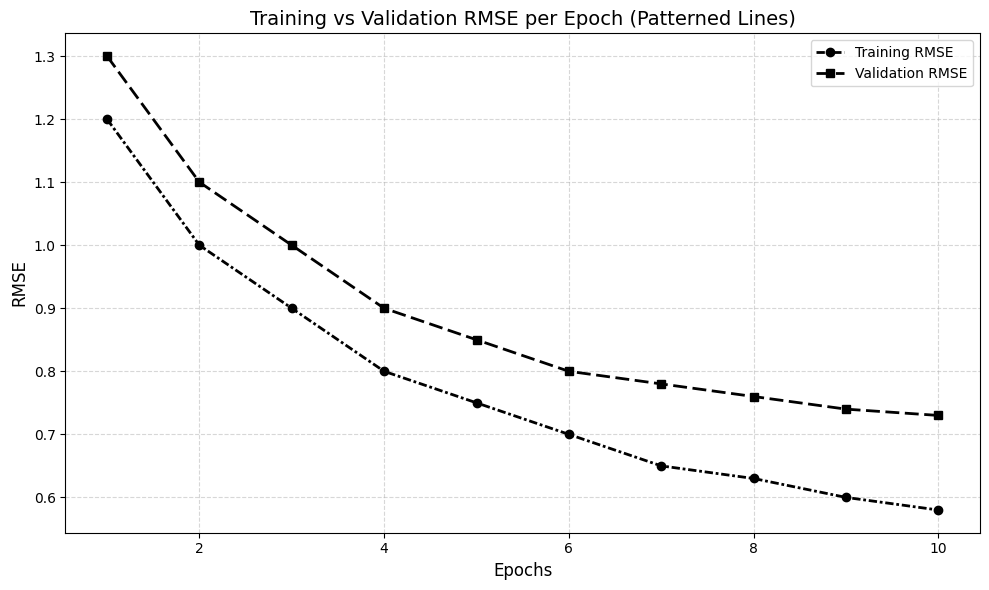

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Data contoh untuk Training dan Validation RMSE per epoch
epochs = list(range(1, 11))  # Misalnya, 10 epoch
training_rmse = [1.2, 1.0, 0.9, 0.8, 0.75, 0.7, 0.65, 0.63, 0.6, 0.58]  # RMSE untuk training
validation_rmse = [1.3, 1.1, 1.0, 0.9, 0.85, 0.8, 0.78, 0.76, 0.74, 0.73]  # RMSE untuk validation

# Membuat grafik Training dan Validation RMSE
plt.figure(figsize=(10, 6))

# Menampilkan garis dengan pola
plt.plot(epochs, training_rmse,
         label='Training RMSE',
         marker='o', linestyle=(0, (3, 1, 1, 1)), linewidth=2, color='black')  # Garis dengan pola putus-putus tebal
plt.plot(epochs, validation_rmse,
         label='Validation RMSE',
         marker='s', linestyle=(0, (5, 2)), linewidth=2, color='black')  # Garis dengan pola strip panjang

# Menambahkan judul dan label
plt.title('Training vs Validation RMSE per Epoch (Patterned Lines)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

# Menampilkan legenda
plt.legend()

# Menambahkan grid untuk kemudahan pembacaan
plt.grid(True, linestyle='--', alpha=0.5)

# Menampilkan grafik
plt.tight_layout()
plt.show()
